In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import xgboost as xgb

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


def load_and_preprocess_data(dataset_path):
    train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
    train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

    df = pd.merge(train_variants, train_text, on="ID")
    df.drop(columns=["ID"], inplace=True)
    df.fillna("Unknown", inplace=True)

    label_encoder = LabelEncoder()
    df["Class"] = label_encoder.fit_transform(df["Class"])
    num_classes = len(label_encoder.classes_)

    gene_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(df[["Gene"]])
    variation_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(df[["Variation"]])

    return df, gene_ohe, variation_ohe, label_encoder, num_classes

def extract_tfidf(df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    return tfidf_vectorizer.fit_transform(df["Text"])

def extract_biobert_embeddings(text_list):
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
    model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to("cuda" if torch.cuda.is_available() else "cpu")
    embeddings = []
    for text in tqdm(text_list, desc="BioBERT"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            output = model(**inputs)
        cls_embedding = output.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embedding.squeeze())
    return np.array(embeddings)

def apply_imbalance_strategy(X, y, strategy):
    if strategy == 'a':
        return SMOTE(random_state=42).fit_resample(X, y)
    elif strategy == 'b':
        return RandomOverSampler(random_state=42).fit_resample(X, y)
    else:
        return X, y

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return loss

def train_xgboost(X_train, y_train, X_test, y_test, use_weights=False):
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train) if use_weights else None
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", num_class=9, objective="multi:softmax")
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_test)
    print("XGBoost Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

def train_keras_nn(X_train, y_train, X_test, y_test, use_focal=False):
    y_train_cat = to_categorical(y_train, num_classes=9)
    y_test_cat = to_categorical(y_test, num_classes=9)

    model = Sequential([
        Dense(512, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(9, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=focal_loss() if use_focal else 'categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat))
    preds = np.argmax(model.predict(X_test), axis=1)
    print("Keras NN Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

def train_stacked_ensemble(X_train, y_train, X_test, y_test):
    base_models = [
        ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")),
        ('rf', RandomForestClassifier()),
        ('et', ExtraTreesClassifier())
    ]
    ensemble = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    print("Stacked Ensemble Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

def train_lightgbm(X_train, y_train, X_test, y_test):
    model = LGBMClassifier()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("LightGBM Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

# === Driver ===
if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"
    df, gene_ohe, variation_ohe, label_encoder, num_classes = load_and_preprocess_data(dataset_path)

    text_mode = input("Choose text feature method (a: TF-IDF, b: BioBERT): ")
    imbalance_mode = input("Choose imbalance handling (a: SMOTE, b: RandomOverSampler, c: Class Weights, d: Focal Loss): ")
    model_type = input("Choose model (a: XGBoost, b: Keras NN, c: Stacked Ensemble, d: LightGBM): ")

    text_features = extract_tfidf(df) if text_mode == 'a' else extract_biobert_embeddings(df["Text"])
    from scipy.sparse import hstack
    X_all = hstack((gene_ohe, variation_ohe, text_features)) if text_mode == 'a' else np.hstack((gene_ohe, variation_ohe, text_features))
    y_all = df["Class"].values

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=42)
    X_train, y_train = apply_imbalance_strategy(X_train, y_train, imbalance_mode)

    if model_type == 'a':
        train_xgboost(X_train, y_train, X_test, y_test, use_weights=(imbalance_mode == 'c'))
    elif model_type == 'b':
        train_keras_nn(X_train, y_train, X_test, y_test, use_focal=(imbalance_mode == 'd'))
    elif model_type == 'c':
        train_stacked_ensemble(X_train, y_train, X_test, y_test)
    elif model_type == 'd':
        train_lightgbm(X_train, y_train, X_test, y_test)


Choose text feature method (a: TF-IDF, b: BioBERT): a
Choose imbalance handling (a: SMOTE, b: RandomOverSampler, c: Class Weights, d: Focal Loss): a
Choose model (a: XGBoost, b: Keras NN, c: Stacked Ensemble, d: LightGBM): a


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6421052631578947
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       114
           1       0.61      0.54      0.57        91
           2       0.62      0.28      0.38        18
           3       0.68      0.65      0.67       137
           4       0.29      0.25      0.27        48
           5       0.80      0.58      0.67        55
           6       0.71      0.85      0.77       191
           7       0.00      0.00      0.00         4
           8       0.83      0.71      0.77         7

    accuracy                           0.64       665
   macro avg       0.57      0.50      0.52       665
weighted avg       0.64      0.64      0.63       665



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os


dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

train_df = pd.merge(train_variants, train_text, on="ID")

train_df.drop(columns=["ID"], inplace=True)

train_df.fillna("Unknown", inplace=True)

label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])

X, y = train_df.drop("Class", axis=1), train_df["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded_train = gene_encoder.fit_transform(X_train[["Gene"]])
variation_encoded_train = variation_encoder.fit_transform(X_train[["Variation"]])

gene_encoded_test = gene_encoder.transform(X_test[["Gene"]])
variation_encoded_test = variation_encoder.transform(X_test[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train["Text"])
X_test_tfidf = tfidf_vectorizer.transform(X_test["Text"])

X_train_ml = hstack((gene_encoded_train, variation_encoded_train, X_train_tfidf))
X_test_ml = hstack((gene_encoded_test, variation_encoded_test, X_test_tfidf))

smote = SMOTE(random_state=42)
X_train_ml_resampled, y_train_ml_resampled = smote.fit_resample(X_train_ml, y_train)


print(f"Train Shape (after SMOTE): {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"Test Shape: {X_test_ml.shape}, Labels: {y_test.shape}")

xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8,
    'objective': "multi:softmax", 'num_class': 9, 'eval_metric': "mlogloss", 'use_label_encoder': False
})

xgb_clf.fit(X_train_ml_resampled, y_train_ml_resampled)

y_pred_test = xgb_clf.predict(X_test_ml)


accuracy = accuracy_score(y_test, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test, y_pred_test))

y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_labels})
predictions_df.to_csv("xgboost_predictions.csv", index=False)

print("Predictions saved to xgboost_predictions.csv!")



Train Shape (after SMOTE): (6858, 7644), Labels: (6858,)
Test Shape: (665, 7644), Labels: (665,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:32:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Test Accuracy: 0.6271

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58       114
           1       0.55      0.53      0.54        91
           2       0.33      0.39      0.36        18
           3       0.68      0.64      0.66       137
           4       0.34      0.44      0.39        48
           5       0.80      0.58      0.67        55
           6       0.73      0.79      0.76       191
           7       0.00      0.00      0.00         4
           8       0.62      0.71      0.67         7

    accuracy                           0.63       665
   macro avg       0.52      0.52      0.51       665
weighted avg       0.63      0.63      0.63       665

Predictions saved to xgboost_predictions.csv!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
import os

import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

train_df = pd.merge(train_variants, train_text, on="ID")
train_df.drop(columns=["ID"], inplace=True)
train_df.fillna("Unknown", inplace=True)

label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Classes 1–9 → 0–8

gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

X_ml = hstack((gene_encoded, variation_encoded, X_tfidf))
y_ml = train_df["Class"]

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

xgb_clf = xgb.XGBClassifier(
    subsample=0.7,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=9,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_ml, y_train_ml)

y_pred_test = xgb_clf.predict(X_test_ml)

accuracy = accuracy_score(y_test_ml, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test_ml, y_pred_test))

y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_labels})
predictions_df.to_csv("xgboost_predictions.csv", index=False)

print(" Predictions saved to xgboost_predictions.csv!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:41:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Test Accuracy: 0.6406

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62       114
           1       0.68      0.47      0.56        91
           2       0.35      0.33      0.34        18
           3       0.65      0.64      0.64       137
           4       0.33      0.33      0.33        48
           5       0.85      0.60      0.70        55
           6       0.69      0.87      0.77       191
           7       0.00      0.00      0.00         4
           8       0.57      0.57      0.57         7

    accuracy                           0.64       665
   macro avg       0.53      0.49      0.50       665
weighted avg       0.64      0.64      0.63       665

✅ Predictions saved to xgboost_predictions.csv!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

train_df = pd.merge(train_variants, train_text, on="ID")
train_df.drop(columns=["ID"], inplace=True)
train_df.fillna("Unknown", inplace=True)

label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])

gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

from scipy.sparse import hstack
X_all = hstack((gene_encoded, variation_encoded, X_tfidf))
y_all = train_df


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-b76229203f64>", line 37, in <cell line: 0>
    X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^

In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

train_df = pd.merge(train_variants, train_text, on="ID")
train_df.drop(columns=["ID"], inplace=True)
train_df.fillna("Unknown", inplace=True)

label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])

gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

svd = TruncatedSVD(n_components=300, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

X_all = np.hstack([gene_encoded, variation_encoded, X_tfidf_reduced])
y_all = train_df["Class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE → X_train:", X_train_resampled.shape, " y_train:", y_train_resampled.shape)

xgb_clf = xgb.XGBClassifier(
    subsample=0.7,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=9,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Final Test Accuracy: {accuracy:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))


y_pred_labels = label_encoder.inverse_transform(y_pred)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_labels})
predictions_df.to_csv("xgboost_svd_smote_predictions.csv", index=False)
print("✅ Saved to xgboost_svd_smote_predictions.csv")


After SMOTE → X_train: (6858, 3560)  y_train: (6858,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:06:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🎯 Final Test Accuracy: 0.6451

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62       114
           1       0.65      0.60      0.62        91
           2       0.25      0.39      0.30        18
           3       0.69      0.67      0.68       137
           4       0.35      0.48      0.41        48
           5       0.77      0.55      0.64        55
           6       0.75      0.77      0.76       191
           7       0.00      0.00      0.00         4
           8       0.62      0.71      0.67         7

    accuracy                           0.65       665
   macro avg       0.52      0.53      0.52       665
weighted avg       0.66      0.65      0.65       665

✅ Saved to xgboost_svd_smote_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)


label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Convert to integers 0–8


gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

X_ml = hstack((gene_encoded, variation_encoded, X_tfidf))
y_ml = train_df["Class"]

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_ml)


xgb_clf = xgb.XGBClassifier(
    subsample=0.7,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=9,
    eval_metric="mlogloss",
    use_label_encoder=False
)

xgb_clf.fit(X_train_ml, y_train_ml, sample_weight=sample_weights)


y_pred_test = xgb_clf.predict(X_test_ml)


accuracy = accuracy_score(y_test_ml, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test_ml, y_pred_test))

-
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_labels})
predictions_df.to_csv("xgboost_weighted_predictions.csv", index=False)

print("Predictions saved to xgboost_weighted_predictions.csv!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:54:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Test Accuracy: 0.6195

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.62      0.61      0.61       114
           1       0.57      0.59      0.58        91
           2       0.29      0.44      0.35        18
           3       0.65      0.56      0.60       137
           4       0.34      0.48      0.40        48
           5       0.82      0.56      0.67        55
           6       0.73      0.76      0.74       191
           7       0.00      0.00      0.00         4
           8       0.62      0.71      0.67         7

    accuracy                           0.62       665
   macro avg       0.52      0.52      0.51       665
weighted avg       0.63      0.62      0.62       665

Predictions saved to xgboost_weighted_predictions.csv!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install transformers==4.30.2 datasets==2.12.0 evaluate sentencepiece
!pip install torch --upgrade --force-reinstall  # or a compatible version
!pip uninstall peft
!pip install --upgrade transformers
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import evaluate  # huggingface evaluate library
from sklearn.model_selection import train_test_split
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(
    os.path.join(dataset_path, "training_text/training_text"),
    sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1
)

df = pd.merge(train_variants, train_text, on="ID").drop(columns=["ID"])
df.fillna("Unknown", inplace=True)

# Class mapping from [1..9] -> [0..8]
class_mapping = {c: c-1 for c in sorted(df["Class"].unique())}
inverse_class_mapping = {v: k for k, v in class_mapping.items()}
df["Class"] = df["Class"].map(class_mapping)

# Combine textual fields (Gene, Variation, and the large Text)
df["combined_text"] = (
    "Gene: " + df["Gene"].astype(str) +
    " | Variation: " + df["Variation"].astype(str) +
    " | " + df["Text"].astype(str)
)

print(df.head(3))
print("Unique classes (mapped):", df["Class"].unique())
X = df["combined_text"].values
y = df["Class"].values

# 70/30
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# from that 30%, take 2/3 as test and 1/3 as val
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2/3), random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))
class CancerTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Flatten because tokenizer returns batch dimension
        item = {k: v.squeeze() for k, v in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item
MODEL_NAME = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = CancerTextDataset(X_train, y_train, tokenizer, max_length=256)
val_dataset   = CancerTextDataset(X_val,   y_val,   tokenizer, max_length=256)
test_dataset  = CancerTextDataset(X_test,  y_test,  tokenizer, max_length=256)
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts

# For each sample in y_train, assign a weight
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=9  # classes [0..8]
).to(device)
batch_size = 8
training_args = TrainingArguments(
    output_dir="bioBERT-checkpoints",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,  # try 3..5..10
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    seed=42
)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_micro = f1_metric.compute(predictions=predictions, references=labels, average="micro")
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    return {
        "accuracy": acc["accuracy"],
        "f1_micro": f1_micro["f1"],
        "f1_macro": f1_macro["f1"]
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # We'll override get_train_dataloader to inject WeightedRandomSampler
)

# We'll override how Trainer creates the train dataloader
def get_train_dataloader():
    return DataLoader(
        train_dataset,
        sampler=sampler,  # Weighted sampler
        batch_size=training_args.per_device_train_batch_size,
        collate_fn=trainer.data_collator
    )

trainer.get_train_dataloader = get_train_dataloader
trainer.train()
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)
from sklearn.metrics import classification_report

predictions_logits, labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions_logits, axis=1)

print("Classification Report (Test):\n", classification_report(labels, preds))
preds_original = [inverse_class_mapping[p] for p in preds]
labels_original = [inverse_class_mapping[l] for l in labels]


  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Usin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'device' is not defined

In [ ]:
!pip install transformers==4.30.2
!pip install sentencepiece  # sometimes needed for tokenizers
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install imblearn
import os
import numpy as np
import pandas as pd

# For text encoding (Hugging Face)
import torch
from transformers import AutoTokenizer, AutoModel

# For model training
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
# Example paths (adjust to your environment)
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(
    os.path.join(dataset_path, "training_text/training_text"),
    sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1
)

# Merge
train_df = pd.merge(train_variants, train_text, on="ID")
train_df.drop(columns=["ID"], inplace=True)

# Fill missing
train_df.fillna("Unknown", inplace=True)

# Map Classes from [1-9] → [0-8]
class_mapping = {label: label-1 for label in sorted(train_df["Class"].unique())}
inverse_class_mapping = {v: k for k, v in class_mapping.items()}
train_df["Class"] = train_df["Class"].map(class_mapping)

print(train_df.head())
print(train_df["Class"].value_counts())
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_ohe = gene_encoder.fit_transform(train_df[["Gene"]])
variation_ohe = variation_encoder.fit_transform(train_df[["Variation"]])

print("Gene OHE Shape:", gene_ohe.shape)
print("Variation OHE Shape:", variation_ohe.shape)

MODEL_NAME = "dmis-lab/biobert-v1.1"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer_model = AutoModel.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
transformer_model.to(device)

def get_bert_embedding(text, max_length=256):
    """
    Returns a single pooled embedding (CLS) for the input text.
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    # Move to GPU if available
    for k, v in inputs.items():
        inputs[k] = v.to(device)

    with torch.no_grad():
        outputs = transformer_model(**inputs)
        # outputs.last_hidden_state.shape = (batch_size=1, seq_len=256, hidden_size=768)
        # We can take the CLS token embedding: outputs.last_hidden_state[:,0,:]
        cls_embedding = outputs.last_hidden_state[:,0,:].squeeze()

    # Return as CPU numpy array
    return cls_embedding.cpu().numpy()

#%%time

all_texts = train_df["Text"].values
bert_embeddings = []

for i, txt in enumerate(all_texts):
    emb = get_bert_embedding(str(txt))
    bert_embeddings.append(emb)

bert_embeddings = np.stack(bert_embeddings)
print("BERT Embeddings Shape:", bert_embeddings.shape)  # (N, 768)

X_full = np.concatenate([gene_ohe, variation_ohe, bert_embeddings], axis=1)
y_full = train_df["Class"].values  # shape (N,)

print("Combined Feature Shape:", X_full.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=2/3, random_state=42, stratify=y_test
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# SMOTE on train only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Train after SMOTE:", X_train_res.shape, y_train_res.shape)

lgb_clf = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    class_weight='balanced',  # extra handle for imbalance
    random_state=42,
    early_stopping_rounds=50,
    verbose=50,
    n_jobs=-1
)

lgb_clf.fit(
    X_train_res, y_train_res,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",

)

# Evaluate
val_preds = lgb_clf.predict(X_val)
test_preds = lgb_clf.predict(X_test)

val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

print("\nClassification Report (Val):")
print(classification_report(y_val, val_preds))
print("Classification Report (Test):")
print(classification_report(y_test, test_preds))

# Convert back to 1-9 if desired
val_preds_original = [inverse_class_mapping[p] for p in val_preds]
test_preds_original = [inverse_class_mapping[p] for p in test_preds]

pd.DataFrame({"Predicted_Class": val_preds_original}).to_csv("lgb_val_predictions.csv", index=False)
pd.DataFrame({"Predicted_Class": test_preds_original}).to_csv("lgb_test_predictions.csv", index=False)


     Gene             Variation  Class  \
0  FAM58A  Truncating Mutations      0   
1     CBL                 W802*      1   
2     CBL                 Q249E      1   
3     CBL                 N454D      2   
4     CBL                 L399V      3   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...  
Class
6    953
3    686
0    568
1    452
5    275
4    242
2     89
8     37
7     19
Name: count, dtype: int64
Gene OHE Shape: (3321, 264)
Variation OHE Shape: (3321, 2996)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERT Embeddings Shape: (3321, 768)
Combined Feature Shape: (3321, 4028)
Train: (2324, 4028) (2324,)
Val:   (332, 4028) (332,)
Test:  (665, 4028) (665,)
Train after SMOTE: (6003, 4028) (6003,)
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.988042
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.162344
[LightGBM] [Debug] init for col-wise cost 0.005802 seconds, init for row-wise cost 0.138446 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 198375
[LightGBM] [Info] Number of data points in the train set: 6003, number of used features: 919
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

In [ ]:
import pandas as pd
import numpy as np
import os

# Sklearn & Imblearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

class_mapping = {label: idx - 1 for idx, label in enumerate(sorted(train_df["Class"].unique()), start=1)}
inverse_class_mapping = {v: k for k, v in class_mapping.items()}
train_df["Class"] = train_df["Class"].map(class_mapping)

gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

X_ml = hstack((gene_encoded, variation_encoded, X_tfidf))
y_ml = train_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=42, stratify=y_test)

print(f"Train Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Shape: {X_test.shape}, Labels: {y_test.shape}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Train Shape after SMOTE: {X_train_resampled.shape}, Labels: {y_train_resampled.shape}")

X_train_resampled = X_train_resampled.toarray()
X_val_dense = X_val.toarray()
X_test_dense = X_test.toarray()

param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced", "balanced_subsample", None]
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=20,         # Number of random parameter combos
    scoring="accuracy",
    cv=3,              # 3-fold CV
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train_resampled, y_train_resampled)

print("Best Hyperparameters:", random_search_rf.best_params_)
print("Best CV Score (Accuracy):", random_search_rf.best_score_)

best_rf = random_search_rf.best_estimator_

y_pred_val = best_rf.predict(X_val_dense)
y_pred_test = best_rf.predict(X_test_dense)

# Convert Predictions (0-8) Back to (1-9)
y_pred_val_original = [inverse_class_mapping[label] for label in y_pred_val]
y_val_original = [inverse_class_mapping[label] for label in y_val]
y_pred_test_original = [inverse_class_mapping[label] for label in y_pred_test]
y_test_original = [inverse_class_mapping[label] for label in y_test]

val_accuracy = accuracy_score(y_val_original, y_pred_val_original)
print(f"Tuned Model Validation Accuracy: {val_accuracy:.4f}")
print("\nTuned Validation Classification Report:\n",
      classification_report(y_val_original, y_pred_val_original))

test_accuracy = accuracy_score(y_test_original, y_pred_test_original)
print(f"Tuned Model Test Accuracy: {test_accuracy:.4f}")
print("\nTuned Test Classification Report:\n",
      classification_report(y_test_original, y_pred_test_original))

val_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_val_original})
test_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})

val_predictions_df.to_csv("tuned_rf_validation_predictions.csv", index=False)
test_predictions_df.to_csv("tuned_rf_test_predictions.csv", index=False)

print("Tuned RF Validation & Test Predictions saved!")



Train Shape: (2324, 8260), Labels: (2324,)
Validation Shape: (332, 8260), Labels: (332,)
Test Shape: (665, 8260), Labels: (665,)
Train Shape after SMOTE: (6003, 8260), Labels: (6003,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': None}
Best CV Score (Accuracy): 0.8592370481425954
Tuned Model Validation Accuracy: 0.6265

Tuned Validation Classification Report:
               precision    recall  f1-score   support

           1       0.49      0.61      0.54        57
           2       0.67      0.53      0.59        45
           3       0.40      0.22      0.29         9
           4       0.63      0.58      0.61        69
           5       0.50      0.46      0.48        24
           6       0.87      0.48      0.62        27
           7       0.70      0.84      0.76        95
           8       0.00      0.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report
import os

# --- 📌 Load Train Data Only ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

# --- 📌 Encode Class Labels (1-9) and Shift for XGBoost (0-8) ---
class_mapping = {label: idx - 1 for idx, label in enumerate(sorted(train_df["Class"].unique()), start=1)}
inverse_class_mapping = {v: k for k, v in class_mapping.items()}
train_df["Class"] = train_df["Class"].map(class_mapping)

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# --- 📌 Concatenate Features for XGBoost ---
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Data (Train 70%, Test 20%, Validation 10%) ---
X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=42, stratify=y_test)

print(f"Train Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Shape: {X_test.shape}, Labels: {y_test.shape}")

# --- 📌 Apply SMOTE (Only on Train Data) ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Train Shape after SMOTE: {X_train_resampled.shape}, Labels: {y_train_resampled.shape}")

# --- 📌 Convert Sparse Matrices to NumPy Arrays ---
X_train_resampled = X_train_resampled.toarray()
X_val = X_val.toarray()
X_test = X_test.toarray()

# --- 📌 Train XGBoost Model ---
xgb_clf = xgb.XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.05, gamma=0.2,
    objective="multi:softmax", num_class=9, eval_metric="mlogloss", use_label_encoder=False
)

xgb_clf.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# --- 📌 Predict on Validation & Test Data ---
y_pred_val = xgb_clf.predict(X_val)
y_pred_test = xgb_clf.predict(X_test)

# Convert Predictions Back to Original Labels
y_pred_val_original = np.array([inverse_class_mapping[label] for label in y_pred_val])
y_pred_test_original = np.array([inverse_class_mapping[label] for label in y_pred_test])
y_val_original = np.array([inverse_class_mapping[label] for label in y_val])
y_test_original = np.array([inverse_class_mapping[label] for label in y_test])

# --- 📌 Evaluate on Validation Data ---
val_accuracy = accuracy_score(y_val_original, y_pred_val_original)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:\n", classification_report(y_val_original, y_pred_val_original))

# --- 📌 Evaluate on Test Data ---
test_accuracy = accuracy_score(y_test_original, y_pred_test_original)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nFinal Classification Report:\n", classification_report(y_test_original, y_pred_test_original))

# --- 📌 Save Predictions ---
val_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_val_original})
test_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})

val_predictions_df.to_csv("xgboost_validation_predictions.csv", index=False)
test_predictions_df.to_csv("xgboost_test_predictions.csv", index=False)

print("Validation & Test Predictions saved to CSV files!")



Train Shape: (2324, 8260), Labels: (2324,)
Validation Shape: (332, 8260), Labels: (332,)
Test Shape: (665, 8260), Labels: (665,)
Train Shape after SMOTE: (6003, 8260), Labels: (6003,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:24:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.13083
[1]	validation_0-mlogloss:2.07294
[2]	validation_0-mlogloss:2.02262
[3]	validation_0-mlogloss:1.97417
[4]	validation_0-mlogloss:1.93053
[5]	validation_0-mlogloss:1.89185
[6]	validation_0-mlogloss:1.85514
[7]	validation_0-mlogloss:1.82082
[8]	validation_0-mlogloss:1.78782
[9]	validation_0-mlogloss:1.75946
[10]	validation_0-mlogloss:1.73203
[11]	validation_0-mlogloss:1.70435
[12]	validation_0-mlogloss:1.67994
[13]	validation_0-mlogloss:1.65563
[14]	validation_0-mlogloss:1.63426
[15]	validation_0-mlogloss:1.61273
[16]	validation_0-mlogloss:1.59302
[17]	validation_0-mlogloss:1.57421
[18]	validation_0-mlogloss:1.55440
[19]	validation_0-mlogloss:1.53642
[20]	validation_0-mlogloss:1.51976
[21]	validation_0-mlogloss:1.50414
[22]	validation_0-mlogloss:1.49075
[23]	validation_0-mlogloss:1.47679
[24]	validation_0-mlogloss:1.46255
[25]	validation_0-mlogloss:1.45055
[26]	validation_0-mlogloss:1.43890
[27]	validation_0-mlogloss:1.42694
[28]	validation_0-mlogloss:1.4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# --- 📌 Define Parameter Grid ---
param_dist = {
    'n_estimators': [100, 300, 500, 700],  # Number of trees
    'max_depth': [3, 5, 7, 9],  # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size
    'gamma': [0, 0.1, 0.2, 0.3],  # Regularization parameter
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # Feature sampling
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Row sampling
    'min_child_weight': [1, 3, 5],  # Minimum weight for new leaves
    'reg_lambda': [0.01, 0.1, 1],  # L2 Regularization
    'reg_alpha': [0, 0.01, 0.1]  # L1 Regularization
}

# --- 📌 Initialize XGBoost Classifier ---
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=9,  # Ensuring it knows there are 9 classes (0-8)
    eval_metric="mlogloss",
    use_label_encoder=False
)

# --- 📌 Randomized Search (Faster Hyperparameter Tuning) ---
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to test (much faster than GridSearch)
    scoring="accuracy",  # Optimize for accuracy
    cv=3,  # 3-fold Cross-validation (faster than 5-fold)
    verbose=2,  # Show training progress
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# --- 📌 Run Hyperparameter Tuning ---
random_search.fit(X_train_resampled, y_train_resampled)

# --- 📌 Print Best Hyperparameters ---
print("Best Hyperparameters:", random_search.best_params_)
print("Best Validation Accuracy:", random_search.best_score_)

# --- 📌 Train Final Model Using Best Hyperparameters ---
best_xgb = random_search.best_estimator_

# --- 📌 Predict on Validation & Test Data ---
y_pred_val = best_xgb.predict(X_val)
y_pred_test = best_xgb.predict(X_test)

# --- 📌 Convert Predictions Back to Original Class Labels ---
y_pred_val_original = np.array([inverse_class_mapping[label] for label in y_pred_val])
y_pred_test_original = np.array([inverse_class_mapping[label] for label in y_pred_test])
y_val_original = np.array([inverse_class_mapping[label] for label in y_val])
y_test_original = np.array([inverse_class_mapping[label] for label in y_test])

# --- 📌 Evaluate on Validation Data ---
val_accuracy = accuracy_score(y_val_original, y_pred_val_original)
print(f"Tuned Model Validation Accuracy: {val_accuracy:.4f}")
print("\nTuned Validation Classification Report:\n", classification_report(y_val_original, y_pred_val_original))

# --- 📌 Evaluate on Test Data ---
test_accuracy = accuracy_score(y_test_original, y_pred_test_original)
print(f"Tuned Model Test Accuracy: {test_accuracy:.4f}")
print("\nTuned Test Classification Report:\n", classification_report(y_test_original, y_pred_test_original))

# --- 📌 Save Predictions ---
val_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_val_original})
test_predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})

val_predictions_df.to_csv("tuned_xgboost_validation_predictions.csv", index=False)
test_predictions_df.to_csv("tuned_xgboost_test_predictions.csv", index=False)

print("Tuned Validation & Test Predictions saved to CSV files!")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os

# --- 📌 Load Train Data Only ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

# --- 📌 Encode Class Labels (1-9) and Shift for XGBoost (0-8) ---
class_mapping = {label: idx - 1 for idx, label in enumerate(sorted(train_df["Class"].unique()), start=1)}
inverse_class_mapping = {v: k for k, v in class_mapping.items()}
train_df["Class"] = train_df["Class"].map(class_mapping)

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# --- 📌 Prepare Data for LSTM ---
MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 128

# Tokenize Text Data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["Text"])
X_train_sequences = tokenizer.texts_to_sequences(train_df["Text"])
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Convert Labels to Categorical for LSTM
y_train_lstm = to_categorical(train_df["Class"])

# --- 📌 Concatenate Features for XGBoost ---
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Train & Test (80-20) ---
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_train_padded, y_train_lstm, test_size=0.2, random_state=42, stratify=y_train_lstm.argmax(axis=1)
)

# --- 📌 Train XGBoost Model on Structured Data ---
xgb_clf = xgb.XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05, gamma=0.2,
    objective="multi:softmax", num_class=9, eval_metric="mlogloss", use_label_encoder=False
)

xgb_clf.fit(X_train_ml, y_train_ml)
xgb_preds = xgb_clf.predict_proba(X_test_ml)

# --- 📌 Train LSTM Model on Text Data ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding

lstm_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(9, activation="softmax")  # 9 classes (0-8)
])

lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.2)

# Predict on Test Data
lstm_preds = lstm_model.predict(X_test_lstm)

# --- 📌 Combine XGBoost & LSTM Predictions ---
final_preds = (xgb_preds + lstm_preds) / 2  # Averaging Predictions
final_labels = np.argmax(final_preds, axis=1)

# Convert Predictions Back to Original Labels
y_pred_test_original = np.array([inverse_class_mapping[label] for label in final_labels])
y_test_ml_original = np.array([inverse_class_mapping[label] for label in y_test_ml])

# --- 📌 Evaluate Hybrid Model ---
accuracy = accuracy_score(y_test_ml_original, y_pred_test_original)
print(f"Hybrid XGBoost + LSTM Accuracy: {accuracy:.4f}")
print("\nHybrid Classification Report:\n", classification_report(y_test_ml_original, y_pred_test_original))

# --- 📌 Save Predictions ---
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})
predictions_df.to_csv("hybrid_xgboost_lstm_predictions.csv", index=False)

print("Predictions saved to hybrid_xgboost_lstm_predictions.csv!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:46:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2656 - loss: 1.9473 - val_accuracy: 0.2970 - val_loss: 1.8446
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2885 - loss: 1.8120 - val_accuracy: 0.4868 - val_loss: 1.5402
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5578 - loss: 1.3422 - val_accuracy: 0.5113 - val_loss: 1.2962
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6754 - loss: 0.9937 - val_accuracy: 0.5977 - val_loss: 1.2342
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7292 - loss: 0.8074 - val_accuracy: 0.5620 - val_loss: 1.3390
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7565 - loss: 0.7319 - val_accuracy: 0.5395 - val_loss: 1.3666
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7803 - loss: 0.6144 - val_accuracy: 0.5564 - val_loss: 1.3885
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7859 - loss: 0.5588 - val_accuracy: 0.5489 - v

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


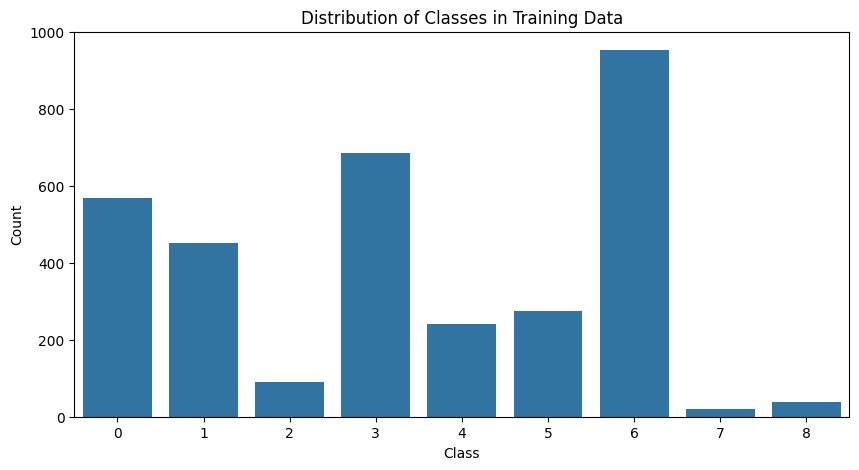

Train Shape (after Oversampling): (2840, 6260), Labels: (2840,)
Test Shape: (665, 6260), Labels: (665,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Improved Test Accuracy: 0.6436

Improved Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.59      0.60       114
           2       0.71      0.46      0.56        91
           3       0.33      0.33      0.33        18
           4       0.69      0.69      0.69       137
           5       0.37      0.44      0.40        48
           6       0.81      0.53      0.64        55
           7       0.69      0.86      0.76       191
           8       0.00      0.00      0.00         4
           9       0.56      0.71      0.62         7

    accuracy                           0.64       665
   macro avg       0.53      0.51      0.51       665
weighted avg       0.65      0.64      0.64       665

Predictions saved to improved_xgboost_predictions.csv!


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- 📌 Load Train Data Only ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

# --- 📌 Manually Map Class Labels (Keeping Them as 1 to 9) ---
class_labels = sorted(train_df["Class"].unique())  # Get sorted class labels (1-9)
class_mapping = {label: idx - 1 for idx, label in enumerate(class_labels, start=1)}  # Map 1-9 to 0-8
inverse_class_mapping = {v: k for k, v in class_mapping.items()}  # Reverse Mapping

# Apply Mapping to Train Data
train_df["Class"] = train_df["Class"].map(class_mapping)  # Shift labels from 1-9 → 0-8

# --- 📌 Plot Class Distribution Before Oversampling ---
plt.figure(figsize=(10,5))
sns.countplot(x=train_df["Class"])
plt.title("Distribution of Classes in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data (With Bigrams) ---
tfidf_vectorizer = TfidfVectorizer(max_features=3000, stop_words="english", ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# Concatenate Features for ML models
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Train & Test (80-20) BEFORE Oversampling ---
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

# --- 📌 Apply Smarter Oversampling (Only on Actual Rare Classes: 3, 8, 9) ---
oversampler = RandomOverSampler(sampling_strategy={2: 100, 7: 100, 8: 100}, random_state=42)
X_train_ml_resampled, y_train_ml_resampled = oversampler.fit_resample(X_train_ml, y_train_ml)

# Print Data Shapes
print(f"Train Shape (after Oversampling): {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"Test Shape: {X_test_ml.shape}, Labels: {y_test_ml.shape}")

# --- 📌 Define Improved XGBoost Model ---
xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.8,
    'n_estimators': 500,  # More estimators for better learning
    'max_depth': 5,  # Slightly deeper trees
    'learning_rate': 0.05,  # Smaller learning rate for stability
    'gamma': 0.2,  # More regularization
    'colsample_bytree': 0.9,
    'scale_pos_weight': "balanced",  # Handle class imbalance
    'objective': "multi:softmax",
    'num_class': 9,  # Ensure XGBoost knows there are 9 classes (0-8)
    'eval_metric': "mlogloss",
    'use_label_encoder': False
})

# --- 📌 Train XGBoost Model on Train Set ---
xgb_clf.fit(X_train_ml_resampled, y_train_ml_resampled)

# --- 📌 Predict on True Test Set ---
y_pred_test = xgb_clf.predict(X_test_ml)

# --- 📌 Convert Predictions Back to Original Class Labels ---
y_pred_test_original = np.array([inverse_class_mapping[label] for label in y_pred_test])
y_test_ml_original = np.array([inverse_class_mapping[label] for label in y_test_ml])

# --- 📌 Evaluate on Test Data ---
accuracy = accuracy_score(y_test_ml_original, y_pred_test_original)
print(f"Improved Test Accuracy: {accuracy:.4f}")
print("\nImproved Classification Report:\n", classification_report(y_test_ml_original, y_pred_test_original))

# --- 📌 Save Predictions ---
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})
predictions_df.to_csv("improved_xgboost_predictions.csv", index=False)

print("Predictions saved to improved_xgboost_predictions.csv!")



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# --- 📌 Define Parameter Grid ---
param_dist = {
    'n_estimators': [100, 300, 500, 700],  # Number of trees
    'max_depth': [3, 5, 7, 9],  # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size
    'gamma': [0, 0.1, 0.2, 0.3],  # Regularization parameter
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],  # Feature sampling
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Row sampling
    'min_child_weight': [1, 3, 5],  # Minimum weight for new leaves
    'reg_lambda': [0.01, 0.1, 1],  # L2 Regularization
    'reg_alpha': [0, 0.01, 0.1]  # L1 Regularization
}

# --- 📌 Initialize XGBoost Classifier ---
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=9,  # Ensuring it knows there are 9 classes (0-8)
    eval_metric="mlogloss",
    use_label_encoder=False
)

# --- 📌 Randomized Search (Faster Hyperparameter Tuning) ---
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to test (much faster than GridSearch)
    scoring="accuracy",  # Optimize for accuracy
    cv=3,  # 3-fold Cross-validation (faster than 5-fold)
    verbose=2,  # Show training progress
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# --- 📌 Run Hyperparameter Tuning ---
random_search.fit(X_train_ml_resampled, y_train_ml_resampled)

# --- 📌 Print Best Hyperparameters ---
print("Best Hyperparameters:", random_search.best_params_)
print("Best Validation Accuracy:", random_search.best_score_)

# --- 📌 Train Final Model Using Best Hyperparameters ---
best_xgb = random_search.best_estimator_

# --- 📌 Predict on Test Data ---
y_pred_test = best_xgb.predict(X_test_ml)

# --- 📌 Convert Predictions Back to Original Class Labels ---
y_pred_test_original = np.array([inverse_class_mapping[label] for label in y_pred_test])
y_test_ml_original = np.array([inverse_class_mapping[label] for label in y_test_ml])

# --- 📌 Evaluate on Test Data ---
accuracy = accuracy_score(y_test_ml_original, y_pred_test_original)
print(f"Tuned Model Test Accuracy: {accuracy:.4f}")
print("\nTuned Classification Report:\n", classification_report(y_test_ml_original, y_pred_test_original))

# --- 📌 Save Predictions ---
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_original})
predictions_df.to_csv("random_tuned_xgboost_predictions.csv", index=False)

print("Predictions saved to random_tuned_xgboost_predictions.csv!")



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:12:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Best Validation Accuracy: 0.6940150008222993
Tuned Model Test Accuracy: 0.6301

Tuned Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.58      0.59       114
           2       0.67      0.46      0.55        91
           3       0.38      0.33      0.35        18
           4       0.67      0.66      0.66       137
           5       0.33      0.31      0.32        48
           6       0.86      0.55      0.67        55
           7       0.66      0.86      0.75       191
           8       0.00      0.00      0.00         4
           9       0.45      0.71      0.56         7

    accuracy                           0.63       665
   macro avg       0.51      0.50      0.49       665
weighted avg       0.63      0.63      0.62 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os

# --- 📌 Load Train Data Only ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

# --- 📌 Encode Class Labels ---
label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Convert to integers

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# Concatenate Features for ML models
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Train & Test (80-20) BEFORE Applying SMOTE ---
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

# --- 📌 Apply SMOTE on Training Data Only ---
smote = SMOTE(random_state=42)
X_train_ml_resampled, y_train_ml_resampled = smote.fit_resample(X_train_ml, y_train_ml)

# Print Data Shapes
print(f"Train Shape (after SMOTE): {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"Test Shape: {X_test_ml.shape}, Labels: {y_test_ml.shape}")

# --- 📌 Define XGBoost Model ---
xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8,
    'objective': "multi:softmax", 'num_class': 9, 'eval_metric': "mlogloss", 'use_label_encoder': False
})

# --- 📌 Train XGBoost Model on Train Set ---
xgb_clf.fit(X_train_ml_resampled, y_train_ml_resampled)

# --- 📌 Predict on True Test Set ---
y_pred_test = xgb_clf.predict(X_test_ml)

# --- 📌 Evaluate on Test Data ---
accuracy = accuracy_score(y_test_ml, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test_ml, y_pred_test))

# --- 📌 Save Predictions ---
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_labels})
predictions_df.to_csv("xgboost_predictions.csv", index=False)

print("Predictions saved to xgboost_predictions.csv!")


Train Shape (after SMOTE): (6858, 8260), Labels: (6858,)
Test Shape: (665, 8260), Labels: (665,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final Test Accuracy: 0.6421

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.61      0.62      0.62       114
           1       0.59      0.56      0.57        91
           2       0.32      0.39      0.35        18
           3       0.70      0.63      0.66       137
           4       0.34      0.44      0.39        48
           5       0.80      0.58      0.67        55
           6       0.74      0.81      0.77       191
           7       0.00      0.00      0.00         4
           8       0.62      0.71      0.67         7

    accuracy                           0.64       665
   macro avg       0.53      0.53      0.52       665
weighted avg       0.65      0.64      0.64       665

Predictions saved to xgboost_predictions.csv!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os

# --- 📌 Load Train Data Only ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)

# --- 📌 Encode Class Labels ---
label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Convert to integers

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])

# Concatenate Features for ML models
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Train & Test (80-20) BEFORE Applying SMOTE ---
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

# --- 📌 Apply SMOTE on Training Data Only ---
smote = SMOTE(random_state=42)
X_train_ml_resampled, y_train_ml_resampled = smote.fit_resample(X_train_ml, y_train_ml)

# Print Data Shapes
print(f"Train Shape (after SMOTE): {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"Test Shape: {X_test_ml.shape}, Labels: {y_test_ml.shape}")

# --- 📌 Define Base Models for Stacking ---
xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8,
    'objective': "multi:softmax", 'num_class': 9, 'eval_metric': "mlogloss", 'use_label_encoder': False
})

rf_clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=200, max_depth=5, random_state=42)

# --- 📌 Create Stacking Model ---
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('extra', extra_trees_clf)
    ],
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
)

# --- 📌 Train Stacking Model on Train Set ---
stacked_model.fit(X_train_ml_resampled, y_train_ml_resampled)

# --- 📌 Predict on True Test Set ---
y_pred_test = stacked_model.predict(X_test_ml)

# --- 📌 Evaluate on Test Data ---
accuracy = accuracy_score(y_test_ml, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test_ml, y_pred_test))

# --- 📌 Save Predictions ---
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
predictions_df = pd.DataFrame({"Predicted_Class": y_pred_test_labels})
predictions_df.to_csv("stacked_model_predictions.csv", index=False)

print("Predictions saved to stacked_model_predictions.csv!")


Train Shape (after SMOTE): (6858, 8260), Labels: (6858,)
Test Shape: (665, 8260), Labels: (665,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
 import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import os

# --- 📌 Load Data ---
dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
test_variants = pd.read_csv(os.path.join(dataset_path, "test_variants/test_variants"))

train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)
test_text = pd.read_csv(os.path.join(dataset_path, "test_text/test_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

# --- 📌 Merge Variants and Text Data ---
train_df = pd.merge(train_variants, train_text, on="ID")
test_df = pd.merge(test_variants, test_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)
test_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)
test_df.fillna("Unknown", inplace=True)

# --- 📌 Encode Class Labels ---
label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Convert to integers

# --- 📌 Encode Gene and Variation (One-Hot Encoding) ---
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# Encode Test Data for ML Model
gene_encoded_test = gene_encoder.transform(test_df[["Gene"]])
variation_encoded_test = variation_encoder.transform(test_df[["Variation"]])

# --- 📌 Apply TF-IDF to Text Data ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Text"])

# Concatenate Features for ML models
X_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
X_test_ml = hstack((gene_encoded_test, variation_encoded_test, X_test_tfidf))
y_ml = train_df["Class"]

# --- 📌 Split Train & Test (80-20) BEFORE Applying SMOTE ---
X_train_ml, X_test_ml_final, y_train_ml, y_test_ml_final = train_test_split(
    X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml
)

# --- 📌 Apply SMOTE on Training Data Only ---
smote = SMOTE(random_state=42)
X_train_ml_resampled, y_train_ml_resampled = smote.fit_resample(X_train_ml, y_train_ml)

# Print Data Shapes
print(f"Train Shape (after SMOTE): {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"Test Shape (Final Test Set): {X_test_ml_final.shape}, Labels: {y_test_ml_final.shape}")

# --- 📌 Define Base Models for Stacking ---
xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8,
    'objective': "multi:softmax", 'num_class': 9, 'eval_metric': "mlogloss", 'use_label_encoder': False
})

rf_clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=200, max_depth=5, random_state=42)

# --- 📌 Create Stacking Model ---
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('extra', extra_trees_clf)
    ],
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
)

# --- 📌 Train Stacking Model on Train Set ---
stacked_model.fit(X_train_ml_resampled, y_train_ml_resampled)

# --- 📌 Predict on True Test Set ---
y_pred_test = stacked_model.predict(X_test_ml_final)

# --- 📌 Evaluate on Test Data ---
accuracy = accuracy_score(y_test_ml_final, y_pred_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print("\nClassification Report on Test Data:\n", classification_report(y_test_ml_final, y_pred_test))

# --- 📌 Save Predictions ---
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)
test_df["Predicted_Class"] = y_pred_test_labels
test_df.to_csv("stacked_model_predictions.csv", index=False)

print("Predictions saved to stacked_model_predictions.csv!")


Train Shape (after SMOTE): (6858, 8260), Labels: (6858,)
Test Shape (Final Test Set): (665, 8260), Labels: (665,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:21:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:47:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:00:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:12:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Final Test Accuracy: 0.6496

Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60       114
           1       0.59      0.56      0.57        91
           2       0.39      0.39      0.39        18
           3       0.69      0.64      0.67       137
           4       0.35      0.44      0.39        48
           5       0.82      0.60      0.69        55
           6       0.75      0.83      0.79       191
           7       0.00      0.00      0.00         4
           8       0.83      0.71      0.77         7

    accuracy                           0.65       665
   macro avg       0.56      0.53      0.54       665
weighted avg       0.65      0.65      0.65       665



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Length of values (665) does not match length of index (5668)

In [ ]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
import os

dataset_path = "/content/drive/MyDrive/msk-redefining-cancer-treatment"

train_variants = pd.read_csv(os.path.join(dataset_path, "training_variants/training_variants"))
test_variants = pd.read_csv(os.path.join(dataset_path, "test_variants/test_variants"))

train_text = pd.read_csv(os.path.join(dataset_path, "training_text/training_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)
test_text = pd.read_csv(os.path.join(dataset_path, "test_text/test_text"), sep="\|\|", engine="python", names=["ID", "Text"], skiprows=1)

In [ ]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Merge Variants and Text Data
train_df = pd.merge(train_variants, train_text, on="ID")
test_df = pd.merge(test_variants, test_text, on="ID")

# Drop ID column (not useful for modeling)
train_df.drop(columns=["ID"], inplace=True)
test_df.drop(columns=["ID"], inplace=True)

# Handle Missing Values
train_df.fillna("Unknown", inplace=True)
test_df.fillna("Unknown", inplace=True)

# Encode Class Labels
label_encoder = LabelEncoder()
train_df["Class"] = label_encoder.fit_transform(train_df["Class"])  # Convert classes to integers
y_train = to_categorical(train_df["Class"])  # Convert to one-hot encoding for DL models

# Encode Gene and Variation (One-Hot Encoding)
gene_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
variation_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

gene_encoded = gene_encoder.fit_transform(train_df[["Gene"]])
variation_encoded = variation_encoder.fit_transform(train_df[["Variation"]])

# Encode Test Data for ML Model
gene_encoded_test = gene_encoder.transform(test_df[["Gene"]])
variation_encoded_test = variation_encoder.transform(test_df[["Variation"]])

# Apply TF-IDF to Text Data (for ML models)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["Text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["Text"])

# Concatenate Features for ML models
X_train_ml = hstack((gene_encoded, variation_encoded, X_train_tfidf))
X_test_ml = hstack((gene_encoded_test, variation_encoded_test, X_test_tfidf))

# Apply SMOTE to Handle Class Imbalance (for ML model)
smote = SMOTE(random_state=42)
X_train_ml_resampled, y_train_ml_resampled = smote.fit_resample(X_train_ml, train_df["Class"])

# Split Training Data for Deep Learning Model
X_train, X_val, y_train_dl, y_val_dl = train_test_split(train_df, y_train, test_size=0.2, random_state=42)

print("Data Preprocessing Completed!")
print(f"ML Training Data Shape: {X_train_ml_resampled.shape}, Labels: {y_train_ml_resampled.shape}")
print(f"DL Training Data Shape: {X_train.shape}, Validation Data Shape: {X_val.shape}")

Data Preprocessing Completed!
ML Training Data Shape: (8577, 8260), Labels: (8577,)
DL Training Data Shape: (2656, 4), Validation Data Shape: (665, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the resampled dataset into Training (80%) and Validation (20%)
X_train_ml_train, X_train_ml_val, y_train_ml_train, y_train_ml_val = train_test_split(
    X_train_ml_resampled, y_train_ml_resampled, test_size=0.2, random_state=42, stratify=y_train_ml_resampled
)

print(f"Training Data Shape: {X_train_ml_train.shape}, Validation Data Shape: {X_train_ml_val.shape}")


Training Data Shape: (6861, 8260), Validation Data Shape: (1716, 8260)


In [ ]:
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Define Base Models
xgb_clf = xgb.XGBClassifier(**{
    'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8,
    'objective': "multi:softmax", 'num_class': 9, 'eval_metric': "mlogloss", 'use_label_encoder': False
})

#lgb_clf = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=5, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=200, max_depth=5, random_state=42)

# Create Stacking Model (Logistic Regression as meta-learner)
stacked_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('extra', extra_trees_clf),
        #('lgb', lgb_clf)
    ],
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
)

# Train Stacking Model
stacked_model.fit(X_train_ml_resampled, y_train_ml_resampled)

# Predict on Validation Data
y_pred_stacked = stacked_model.predict(X_train_ml_val)

# Evaluate Model Performance
accuracy = accuracy_score(y_train_ml_val, y_pred_stacked)
print(f"Stacked Model Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_train_ml_val, y_pred_stacked))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:53:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:26:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:58:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Stacked Model Validation Accuracy: 0.9435

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       191
           1       1.00      0.90      0.95       190
           2       0.93      0.98      0.95       191
           3       0.90      0.93      0.92       191
           4       0.91      0.92      0.92       191
           5       0.94      0.98      0.96       190
           6       0.89      0.91      0.90       191
           7       1.00      1.00      1.00       190
           8       1.00      1.00      1.00       191

    accuracy                           0.94      1716
   macro avg       0.94      0.94      0.94      1716
weighted avg       0.94      0.94      0.94      1716



In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('extra', extra_trees_clf),
        #('lgb', lgb_clf)
    ],
    voting='soft'  # Soft Voting: Uses predicted probabilities for better performance
)

# Train Voting Model
voting_clf.fit(X_train_ml_resampled, y_train_ml_resampled)

# Predict on Validation Data
y_pred_voting = voting_clf.predict(X_train_ml_val)

# Evaluate Model Performance
accuracy = accuracy_score(y_train_ml_val, y_pred_voting)
print(f"Voting Model Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_train_ml_val, y_pred_voting))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:05:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Model Validation Accuracy: 0.9359

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85       191
           1       0.98      0.93      0.95       190
           2       0.90      0.98      0.94       191
           3       0.92      0.91      0.91       191
           4       0.84      0.94      0.88       191
           5       0.95      0.97      0.96       190
           6       0.95      0.90      0.92       191
           7       1.00      1.00      1.00       190
           8       1.00      1.00      1.00       191

    accuracy                           0.94      1716
   macro avg       0.94      0.94      0.94      1716
weighted avg       0.94      0.94      0.94      1716



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the resampled data for training and validation
X_train_ml_train, X_train_ml_val, y_train_ml_train, y_train_ml_val = train_test_split(
    X_train_ml_resampled, y_train_ml_resampled, test_size=0.2, random_state=42
)

# Define XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=9, eval_metric="mlogloss", use_label_encoder=False
)

# Train Model
xgb_model.fit(X_train_ml_train, y_train_ml_train)

# Predict on Validation Set
y_pred_val = xgb_model.predict(X_train_ml_val)

# Evaluate Model Performance
accuracy = accuracy_score(y_train_ml_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_train_ml_val, y_pred_val))

# Predict on Test Set
y_pred_test = xgb_model.predict(X_test_ml)

# Convert Predictions Back to Original Labels
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)

# Save Predictions
test_df["Predicted_Class"] = y_pred_test_labels
test_df.to_csv("xgboost_predictions.csv", index=False)

print("Predictions saved to xgboost_predictions.csv!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:02:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.8712

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       201
           1       0.83      0.81      0.82       186
           2       0.97      0.97      0.97       193
           3       0.79      0.78      0.79       194
           4       0.82      0.86      0.84       177
           5       0.98      0.91      0.94       206
           6       0.70      0.79      0.74       194
           7       1.00      1.00      1.00       182
           8       1.00      0.99      0.99       183

    accuracy                           0.87      1716
   macro avg       0.88      0.87      0.87      1716
weighted avg       0.87      0.87      0.87      1716

Predictions saved to xgboost_predictions.csv!


In [ ]:
# Predict on Training Set
y_pred_train = xgb_model.predict(X_train_ml_train)

# Calculate Training Accuracy
train_accuracy = accuracy_score(y_train_ml_train, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")


NotFittedError: need to call fit or load_model beforehand

In [ ]:
pip install xgboost scikit-learn imbalanced-learn


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=9, eval_metric="mlogloss", use_label_encoder=False
)

# Reduce the hyperparameter search space for speed
param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "gamma": [0, 0.1]
}

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist,
    n_iter=2, scoring="accuracy", cv=3, verbose=1, n_jobs=-1, random_state=42
)

# Train with reduced search space
random_search.fit(X_train_ml_resampled, y_train_ml_resampled)

# Get the best model
best_xgb = random_search.best_estimator_

# Print best parameters and accuracy
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Validation Accuracy: {random_search.best_score_:.4f}")

# Evaluate on validation set
y_pred_val = best_xgb.predict(X_train_ml_val)
accuracy = accuracy_score(y_train_ml_val, y_pred_val)
print(f"Validation Accuracy (Tuned Model): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_train_ml_val, y_pred_val))

# Predict on test data
y_pred_test = best_xgb.predict(X_test_ml)

# Convert predictions back to original labels
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test)

# Save predictions
test_df["Predicted_Class"] = y_pred_test_labels
test_df.to_csv("xgboost_tuned_predictions.csv", index=False)

print("Optimized XGBoost predictions saved to xgboost_tuned_predictions.csv!")


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:19:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best Validation Accuracy: 0.8174
Validation Accuracy (Tuned Model): 0.9429

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87       201
           1       0.97      0.94      0.96       186
           2       0.96      0.99      0.98       193
           3       0.91      0.92      0.92       194
           4       0.82      0.95      0.88       177
           5       0.98      0.97      0.97       206
           6       0.93      0.90      0.91       194
           7       1.00      1.00      1.00       182
           8       1.00      1.00      1.00       183

    accuracy                           0.94      1716
   macro avg       0.94      0.94      0.94      1716
weighted avg       0.94      0.94      0.94      1716

Optimized XGBoost predictions saved to xgboost_tuned_pre

In [ ]:
!pip install autoviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [ ]:
import pandas as pd
import os
from autoviz.AutoViz_Class import AutoViz_Class

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [ ]:
# merging structured and text data with id
train_data = pd.merge(train_variants, train_text, on="ID", how="left")
test_data = pd.merge(test_variants, test_text, on="ID", how="left")


train_data.head()

ID   Gene        Variation        Class  \
0   0  FAM58A  Truncating Mutations    1     
1   1     CBL                 W802*    2     
2   2     CBL                 Q249E    2     
3   3     CBL                 N454D    3     
4   4     CBL                 L399V    4     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# Display dataset shape
train_data.shape, test_data.shape

((3321, 5), (5668, 4))

In [ ]:
AV = AutoViz_Class()

# Run AutoViz on structured data (train_variants)
auto_report = AV.AutoViz(filename="", dfte=train_variants, depVar="Class", verbose=2)


Shape of your Data Set loaded: (3321, 4)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : []
    Integer-Categorical Columns: []
    String-Categorical Columns: []
    Factor-Categorical Columns: []
    String-Boolean Columns: []
    Numeric-Boolean Columns: []
    Discrete String Columns: ['Gene']
    NLP text Columns: ['Variation']
    Date Time Columns: []
    ID Columns: ['ID']
    Columns that will not be considered in modeling: []
    3 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['ID']

################ Multi_Classification problem #####################
   Columns to

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Gene,object,0.000000,7,,,Possible high cardinality column with 264 unique values: Use hash encoding or text embedding to reduce dimension.
Variation,object,0.000000,90,,,No issue
Class,int64,0.000000,0,1.000000,9.000000,Target column. Appears to have Imbalanced classes. Try balancing classes.


No continuous var in data set: drawing categorical distribution plots


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Could not draw wordcloud plot for Variation. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Gene. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

All Plots are saved in ./AutoViz_Plots/Class
Time to run AutoViz = 8 seconds 


[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection popular


In [ ]:
auto_report_merged = AV.AutoViz(filename="", dfte=train_data, depVar="Class", verbose=2)


Shape of your Data Set loaded: (3321, 5)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : []
    Integer-Categorical Columns: []
    String-Categorical Columns: []
    Factor-Categorical Columns: []
    String-Boolean Columns: []
    Numeric-Boolean Columns: []
    Discrete String Columns: ['Gene']
    NLP text Columns: ['Variation', 'Text']
    Date Time Columns: []
    ID Columns: ['ID']
    Columns that will not be considered in modeling: []
    4 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['ID']

################ Multi_Classification problem #####################
   Co

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
Gene,object,0.000000,7,,,Possible high cardinality column with 264 unique values: Use hash encoding or text embedding to reduce dimension.
Variation,object,0.000000,90,,,No issue
Text,object,0.150557,57,,,"5 missing values. Impute them with mean, median, mode, or a constant value such as 123., Mixed dtypes: has 2 different data types: object, float,"
Class,int64,0.000000,0,1.000000,9.000000,Target column. Appears to have Imbalanced classes. Try balancing classes.


No continuous var in data set: drawing categorical distribution plots


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

Could not draw wordcloud plot for Variation. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Text. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.

Could not draw wordcloud plot for Gene. 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk

In [ ]:
from sklearn.preprocessing import LabelEncoder

# encoding gene and variation for training data
gene_encoder = LabelEncoder()
variation_encoder = LabelEncoder()

train_data["Gene"] = gene_encoder.fit_transform(train_data["Gene"])
train_data["Variation"] = variation_encoder.fit_transform(train_data["Variation"])

# function to safely encode test data, so we can address unseen label in test data
def encode_with_fallback(encoder, data_column, train_labels):
    mapping = {label: idx for idx, label in enumerate(train_labels)}
    return data_column.apply(lambda x: mapping.get(x, -1))  # assign -1 for unseen labels

# encoding test data (handling unseen labels)
test_data["Gene"] = encode_with_fallback(gene_encoder, test_data["Gene"], gene_encoder.classes_)
test_data["Variation"] = encode_with_fallback(variation_encoder, test_data["Variation"], variation_encoder.classes_)

# converting -1 labels to a new category index
test_data["Gene"] = test_data["Gene"].replace(-1, len(gene_encoder.classes_))
test_data["Variation"] = test_data["Variation"].replace(-1, len(variation_encoder.classes_))

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical

num_classes = train_data["Class"].nunique()
train_labels = to_categorical(train_data["Class"] - 1, num_classes=num_classes)

train_data.head(), test_data.head()



(   ID  Gene  Variation  Class  \
 0   0    85       2629      1   
 1   1    39       2856      2   
 2   2    39       1897      2   
 3   3    39       1667      3   
 4   4    39       1447      4   
 
                                                 Text  
 0  Cyclin-dependent kinases (CDKs) regulate a var...  
 1   Abstract Background  Non-small cell lung canc...  
 2   Abstract Background  Non-small cell lung canc...  
 3  Recent evidence has demonstrated that acquired...  
 4  Oncogenic mutations in the monomeric Casitas B...  ,
    ID  Gene  Variation                                               Text
 0   0   264       2996  2. This mutation resulted in a myeloproliferat...
 1   1   264       2996   Abstract The Large Tumor Suppressor 1 (LATS1)...
 2   2   264       2996  Vascular endothelial growth factor receptor (V...
 3   3   264       2996  Inflammatory myofibroblastic tumor (IMT) is a ...
 4   4   264       2996   Abstract Retinoblastoma is a pediatric retina...)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text preprocessing parameters
MAX_WORDS = 30000  # Increased vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Maximum sequence length

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(train_data["Text"].fillna(""))

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data["Text"].fillna(""))
test_sequences = tokenizer.texts_to_sequences(test_data["Text"].fillna(""))

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Display sequence shape
train_padded.shape, test_padded.shape




((3321, 500), (5668, 500))

In [ ]:
embedding_dim = 100  # Size of the word embedding vectors


In [ ]:
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Dropout, Attention, Flatten
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.optimizers.schedules import ExponentialDecay
#
## Learning rate scheduler
#lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=5000, decay_rate=0.8)
#optimizer = Adam(learning_rate=lr_schedule)
#
## Text Input (LSTM Branch)
#text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="Text_Input")
#embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, trainable=True)(text_input)
#lstm_layer = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(embedding_layer)
#lstm_layer2 = Bidirectional(LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))(lstm_layer)
#
## Attention Layer
#attention = Attention()([lstm_layer, lstm_layer])
#lstm_output = Flatten()(attention)
#
## Gene Input
#gene_input = Input(shape=(1,), name="Gene_Input")
#gene_embedding = Embedding(input_dim=len(gene_encoder.classes_)+1, output_dim=8)(gene_input)
#gene_embedding = Flatten()(gene_embedding)
#
## Variation Input
#variation_input = Input(shape=(1,), name="Variation_Input")
#variation_embedding = Embedding(input_dim=len(variation_encoder.classes_)+1, output_dim=8)(variation_input)
#variation_embedding = Flatten()(variation_embedding)
#
## Merge Inputs
#merged = Concatenate()([lstm_output, gene_embedding, variation_embedding])
#dense1 = Dense(64, activation="relu")(merged)
#dropout = Dropout(0.5)(dense1)
#dense2 = Dense(32, activation="relu")(dropout)
#dropout2 = Dropout(0.5)(dense2)
#output = Dense(num_classes, activation="softmax")(dropout2)
#
## Build Model
#model = Model(inputs=[text_input, gene_input, variation_input], outputs=output)
#model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
#
## Early Stopping Callback
##early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
#
## Train Model
#history = model.fit(
#    [train_padded, train_data["Gene"], train_data["Variation"]],
#    train_labels,
#    validation_split=0.2,
#    epochs=40,
#    batch_size=32,
#    verbose=1,
#    #callbacks=[early_stop]
#)


Epoch 1/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.2102 - loss: 2.1270 - val_accuracy: 0.2617 - val_loss: 2.0159
Epoch 2/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.3890 - loss: 1.7515 - val_accuracy: 0.3639 - val_loss: 1.8316
Epoch 3/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.4501 - loss: 1.6020 - val_accuracy: 0.3624 - val_loss: 1.6693
Epoch 4/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4848 - loss: 1.5099 - val_accuracy: 0.3368 - val_loss: 1.8177
Epoch 5/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5033 - loss: 1.4182 - val_accuracy: 0.3429 - val_loss: 1.8053
Epoch 6/40
83/83 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5247 - loss: 1.2903 - val_accuracy: 0.3579 - val_loss: 1.7352


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Dropout, Attention, Flatten

# Text Input
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name="Text_Input")
embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, trainable=True)(text_input)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(embedding_layer)

# Attention Layer
attention = Attention()([lstm_layer, lstm_layer])
lstm_output = Flatten()(attention)

# Gene Input
gene_input = Input(shape=(1,), name="Gene_Input")
gene_embedding = Embedding(input_dim=len(gene_encoder.classes_)+1, output_dim=8)(gene_input)
gene_embedding = Flatten()(gene_embedding)

# Variation Input
variation_input = Input(shape=(1,), name="Variation_Input")
variation_embedding = Embedding(input_dim=len(variation_encoder.classes_)+1, output_dim=8)(variation_input)
variation_embedding = Flatten()(variation_embedding)

# Merge Inputs
merged = Concatenate()([lstm_output, gene_embedding, variation_embedding])
dense1 = Dense(128, activation="relu")(merged)
dropout = Dropout(0.4)(dense1)
dense2 = Dense(64, activation="relu")(dropout)
dropout2 = Dropout(0.3)(dense2)
output = Dense(num_classes, activation="softmax")(dropout2)

# Build model
model = Model(inputs=[text_input, gene_input, variation_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Text_Input (InputLayer)   │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 500, 100)       │      3,000,000 │ Text_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 500, 256)       │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Gene_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Variation_Input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 500, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 8)           │          2,120 │ Gene_Input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 8)           │         23,976 │ Variation_Input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128000)         │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 8)              │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 8)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128016)         │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0],       │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │     16,386,176 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 9)              │            585 │ dropout_1[0][0]        │
└──────────────────────

 Total params: 19,655,609 (74.98 MB)

 Trainable params: 19,655,609 (74.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare structured inputs
train_structured = train_data[["Gene", "Variation"]].values
test_structured = test_data[["Gene", "Variation"]].values

# Train the model
history = model.fit(
    [train_padded, train_structured[:, 0], train_structured[:, 1]],
    train_labels,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)



Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.3139 - loss: 1.8587 - val_accuracy: 0.3579 - val_loss: 1.8502
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4838 - loss: 1.4379 - val_accuracy: 0.4015 - val_loss: 1.6393
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.6005 - loss: 1.1588 - val_accuracy: 0.4105 - val_loss: 1.5484
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6510 - loss: 1.0680 - val_accuracy: 0.3323 - val_loss: 1.7061
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6863 - loss: 0.9339 - val_accuracy: 0.4045 - val_loss: 1.7335
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6814 - loss: 0.9694 - val_accuracy: 0.4075 - val_loss: 1.5627
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7177 - loss: 0.8422 - val_accuracy: 0.3940 - val_loss: 1.8246
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7330 - loss: 0.7465 - val_accuracy: 0.3774 - v

In [ ]:
# Save model
#model.save("/content/drive/MyDrive/biobert_genetic_mutation_classifier.h5")

# Make predictions (if test labels available)
# test_predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"], test_structured])
